In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import wget
import dask
import os
from tqdm import tqdm
import glob
import os

from numpy import linalg as LA
import math
import sklearn.preprocessing
import bahc
import pyRMT

%matplotlib inline

In [2]:
merge = []
opt = []
for i in range(300, 1500, 100):
    no = pd.read_pickle(f"in_out_risk_no_{i}_.pkl")
    eig = pd.read_pickle(f"in_out_risk_eig_{i}_.pkl")
    nls = pd.read_pickle(f"in_out_risk_nls_{i}_.pkl")
    bahc = pd.read_pickle(f"in_out_risk_bahc_{i}_.pkl")
    no = no.mean()
    eig = eig.mean()
    nls = nls.mean()
    bahc = bahc.mean()
    opt.append(pd.concat([no, eig, nls, bahc]))
    for i in range(len(no)):
        no[i] = math.sqrt(no[i])
        nls[i] = math.sqrt(nls[i])
        bahc[i] = math.sqrt(bahc[i])
        eig[i] = math.sqrt(eig[i])
    merge.append(pd.concat([no, eig, nls, bahc]))
opt = pd.concat(opt, axis=1).T
opt["no"] = opt["no_arr_out"] / opt["no_arr_in"] - 1
opt["nls"] = opt["nls_arr_out"] / opt["nls_arr_in"] - 1
opt["bahc"] = opt["bahc_arr_out"] / opt["bahc_arr_in"] - 1
opt["eig"] = opt["eig_arr_out"] / opt["eig_arr_in"] - 1
opt = opt.drop(columns=["no_arr_in", "no_arr_out", "nls_arr_out", "nls_arr_in", "bahc_arr_out", "bahc_arr_in", "eig_arr_out", "eig_arr_in"])
opt.index = range(300, 1500, 100)
print(opt)
risk = pd.concat(merge, axis=1)
risk = risk.T
risk.index = range(300, 1500, 100)
risk

              no       nls      bahc       eig
300   178.236388 -0.099847  0.396855 -0.107134
400    37.110558 -0.116142  0.231552 -0.123758
500    20.552604 -0.131628  0.139052 -0.140268
600    14.422998 -0.145655  0.073188 -0.155756
700    11.437105 -0.155661  0.028601 -0.167199
800     9.445718 -0.165799 -0.012401 -0.177870
900     7.754334 -0.177208 -0.045468 -0.191510
1000    6.511232 -0.191469 -0.075566 -0.207827
1100    5.508842 -0.207617 -0.103203 -0.225544
1200    4.754395 -0.225349 -0.128876 -0.244597
1300    4.146155 -0.244819 -0.153864 -0.264327
1400    3.648680 -0.265041 -0.177337 -0.284915


,no_arr_in,no_arr_out,eig_arr_in,eig_arr_out,nls_arr_in,nls_arr_out,bahc_arr_in,bahc_arr_out
300,0.000065,0.000871,0.009953,0.009405,0.010616,0.010072,0.000471,0.000557
400,0.000111,0.000686,0.009951,0.009315,0.010680,0.010041,0.000501,0.000556
500,0.000140,0.000649,0.009953,0.009228,0.010692,0.009964,0.000523,0.000558
600,0.000161,0.000631,0.009949,0.009141,0.010692,0.009883,0.000542,0.000561
700,0.000177,0.000624,0.009926,0.009059,0.010673,0.009807,0.000555,0.000563
800,0.000192,0.000621,0.009895,0.008972,0.010630,0.009709,0.000570,0.000566
900,0.000208,0.000615,0.009868,0.008873,0.010571,0.009589,0.000581,0.000568
1000,0.000222,0.000608,0.009847,0.008764,0.010526,0.009465,0.000591,0.000568
1100,0.000235,0.000599,0.009829,0.008650,0.010493,0.009340,0.000600,0.000568
1200,0.000246,0.000591,0.009816,0.008531,0.010469,0.009214,0.000608,0.000567


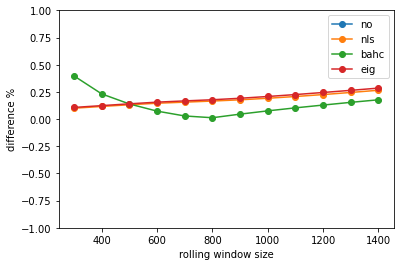

In [3]:
plt.plot(opt.abs(), 'o-')
plt.ylabel("difference %")
plt.xlabel("rolling window size")
plt.legend(["no", "nls", "bahc", "eig"])
plt.ylim(bottom=-1, top=1)
plt.show()

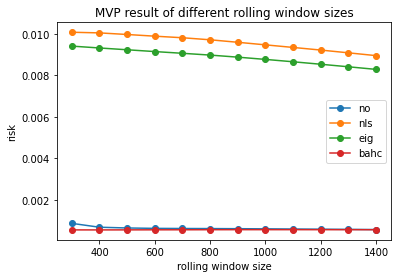

In [4]:
plt.plot(risk[["no_arr_out", "nls_arr_out", "eig_arr_out", "bahc_arr_out"]], 'o-')
plt.ylabel("risk")
plt.xlabel("rolling window size")
plt.legend(["no", "nls", "eig", "bahc"])
plt.title("MVP result of different rolling window sizes")
# plt.ylim(bottom=0, top=0.002)
plt.show()

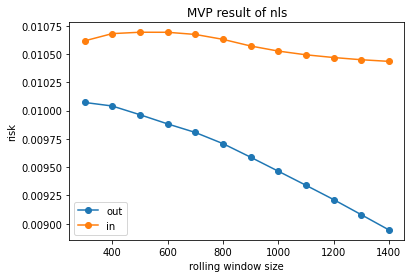

In [5]:
plt.plot(risk[["nls_arr_out", "nls_arr_in"]], 'o-')
plt.ylabel("risk")
plt.xlabel("rolling window size")
plt.legend(["out", "in"])
plt.title("MVP result of nls")
# plt.ylim(bottom=0, top=0.002)
plt.show()

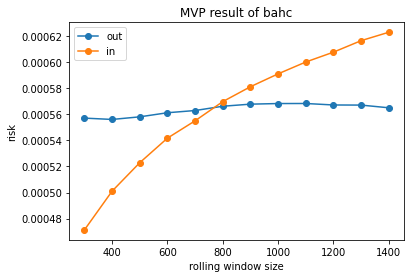

In [6]:
plt.plot(risk[["bahc_arr_out", "bahc_arr_in"]], 'o-')
plt.ylabel("risk")
plt.xlabel("rolling window size")
plt.legend(["out", "in"])
plt.title("MVP result of bahc")
# plt.ylim(bottom=0, top=0.002)
plt.show()

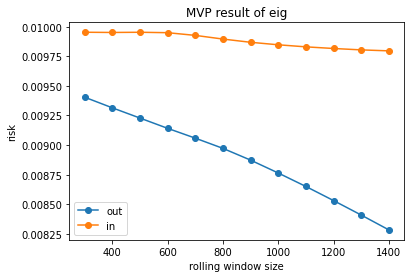

In [7]:
plt.plot(risk[["eig_arr_out", "eig_arr_in"]], 'o-')
plt.ylabel("risk")
plt.xlabel("rolling window size")
plt.legend(["out", "in"])
plt.title("MVP result of eig")
# plt.ylim(bottom=0, top=0.002)
plt.show()

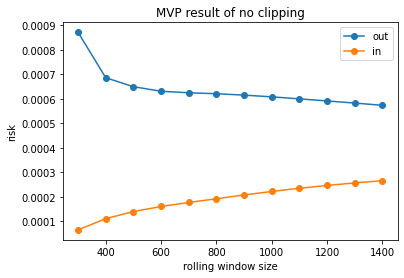

In [8]:
plt.plot(risk[["no_arr_out", "no_arr_in"]], 'o-')
plt.ylabel("risk")
plt.xlabel("rolling window size")
plt.legend(["out", "in"])
plt.title("MVP result of no clipping")
# plt.ylim(bottom=0, top=0.002)
plt.show()

<AxesSubplot: title={'center': 'MVP in rolling window'}, xlabel='Time (hour)', ylabel='risk'>

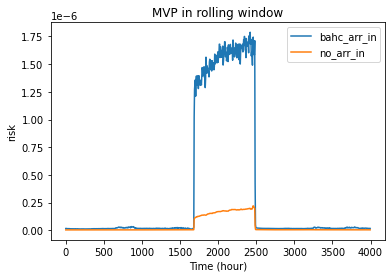

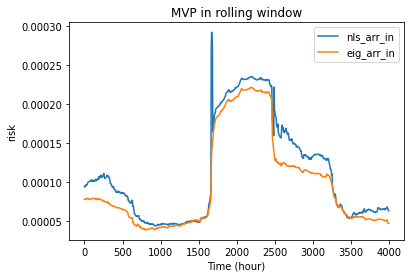

In [9]:
nls = pd.read_pickle("in_out_risk_nls_800_.pkl")
eig = pd.read_pickle("in_out_risk_eig_800_.pkl")
for i in eig.columns:
    eig[i] = eig[i].apply(lambda x: x.item(0))
no = pd.read_pickle("in_out_risk_no_800_.pkl")
bahc = pd.read_pickle("in_out_risk_bahc_800_.pkl")
# outwindow = pd.concat([bahc[["bahc_arr_out"]], no[["no_arr_out"]]], axis=1)
# outwindow.index = range(800, 4000+800, 5)
# outwindow.index += 8000
# outwindow.plot(xlabel="Time (hour)", ylabel="risk")
inwindow = pd.concat([bahc[["bahc_arr_in"]], no[["no_arr_in"]]], axis=1)
inwindow.index = range(0, 4000, 5)
inwindow.plot(xlabel="Time (hour)", ylabel="risk", title="MVP in rolling window")
inwindow = pd.concat([nls[["nls_arr_in"]], eig[["eig_arr_in"]]], axis=1)
inwindow.index = range(0, 4000, 5)
inwindow.plot(xlabel="Time (hour)", ylabel="risk", title="MVP in rolling window")